<a href="https://colab.research.google.com/github/khaerensml6/uva_exercise/blob/main/uva_diffusion_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data exploration: LAION-5B



In [168]:
import math
from PIL import Image


In [169]:

def crop_image(original_image, size=124):

    if original_image.size[0] < original_image.size[1]:
        resized_image = original_image.resize(
            (size, int(size * original_image.size[1] / original_image.size[0])))
    else:
        resized_image = original_image.resize(
            (int(size * original_image.size[0] / original_image.size[1]), size))

    w, h = resized_image.size
    left = (w - size) // 2
    top = (h - size) // 2
    right = (w + size) // 2
    bottom = (h + size) // 2

    cropped_image = resized_image.crop((left, top, right, bottom))

    return cropped_image

def image_grid(imgs, rows, cols):

    w, h = 124, 124
    imgs = [crop_image(img, w) for img in imgs]

    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [178]:
number_of_images = 20
aesthetic_score = 9 # number from 1-10: "prettiness" of the images to retrieve
aesthetic_weight = 0.5

In [179]:
from clip_client import ClipClient, Modality

laion_client = ClipClient(
            url="https://knn.laion.ai/knn-service",
            indice_name="laion5B-L-14",
            num_images=number_of_images,
            aesthetic_score=aesthetic_score,
            aesthetic_weight=aesthetic_weight,
            modality=Modality.IMAGE,
        )

## Querying LAION with text

In [180]:
query_string = "cat with hat"

In [181]:
retrieved_images = laion_client.query(text=query_string)
print(f"Found {len(retrieved_images)} image urls!")

Found 14 image urls!


In [182]:
from PIL import Image
import requests
import io

images = []
for i, response in enumerate(retrieved_images):
  image_url = response["url"]
  try:

    dataBytesIO = io.BytesIO(requests.get(image_url, stream=True).content)
    image = Image.open(dataBytesIO)
    images.append(image)

    print(f"Found image {i} with caption: \n\t \"{response['caption']}\"\n")
  except Exception as e:
    print(f"encountered a dead link for image {i}!\n")

encountered a dead link for image 0!

Found image 1 with caption: 
	 "Кот, который всегда на расслабоне"

encountered a dead link for image 2!

Found image 3 with caption: 
	 "Cat wearing straw hat Stock Photography"

encountered a dead link for image 4!

Found image 5 with caption: 
	 "1 1/2 Fabric Cat Button - CLOWNING Around Cat in Hat"

Found image 6 with caption: 
	 "Cat wearing straw hat Royalty Free Stock Photos"

Found image 7 with caption: 
	 "Grey Cat in Santa Hat hanging Christmas tree decoration - NEW shape & design for Christmas 2016. Made from felt and finished with a red love heart, collar, bead eyes and a hanging loop. | eBay!"

Found image 8 with caption: 
	 "Tabby Gray Cat Scarf Knitting Scarf Gray Scarf Cowl Scarf Long Scarf knit, winter scarf, Christmas Gift, Multicolor Scarf Tabby Gray Cat Scarf Knitting Scarf Gray Scarf Cowl by EastalaceKnitting Patterns Mittens nice soft and warm scarf. Fox Scarf, Hand Knit Scarf, Grey Scarf, Knitted Cat, Cat Crochet, Kids Croche

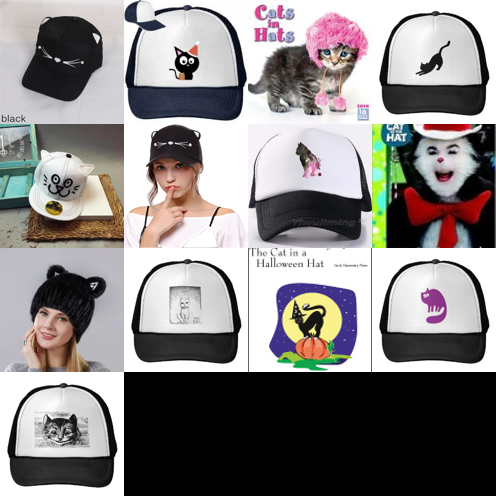

In [177]:
image_grid(images, rows=math.ceil(len(images)/4), cols=4 )

## Querying LAION with an image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   638k      0 --:--:-- --:--:-- --:--:--  639k


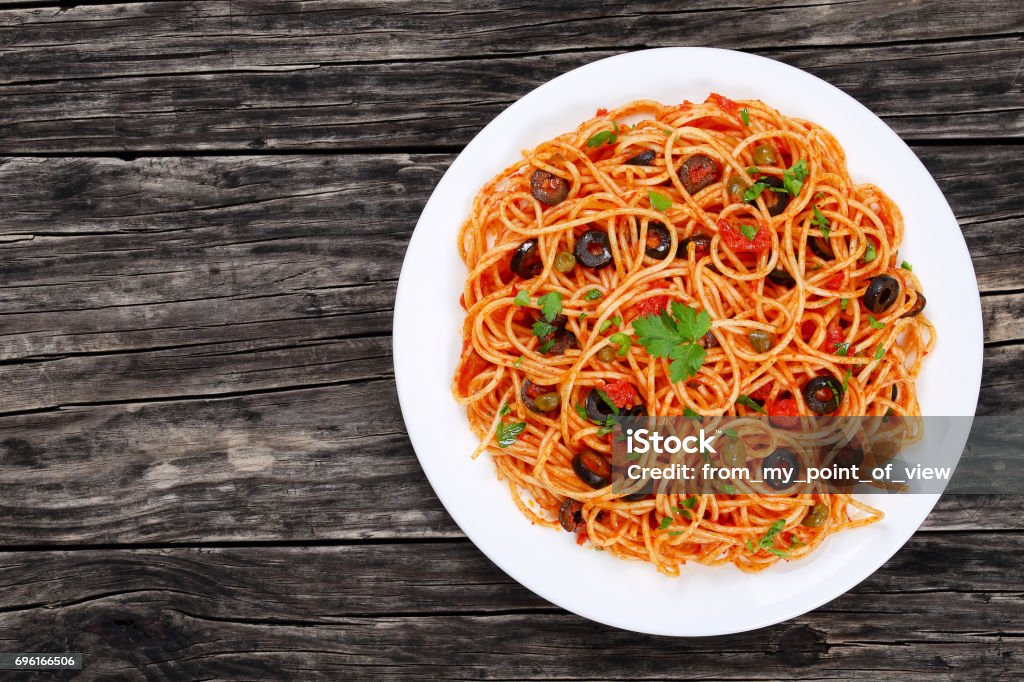

In [162]:

# download a sample query image:
# or comment out the line below and upload your own image under the name "query_image.png"
!curl "https://media.istockphoto.com/photos/paghetti-with-tomato-sauce-capers-and-olives-picture-id696166506?k=6&amp;m=696166506&amp;s=612x612&amp;w=0&amp;h=-hV4BZr3ekV0tJQ2x-vg_sSQKXm7qaqzDgl8fDEp9NE=" > query_image.png
query_image = Image.open("query_image.png")

query_image


In [163]:

laion_client.num_images=30
retrieved_images = laion_client.query(image="query_image.png")
print(f"Found {len(retrieved_images)} images")


Found 13 images
[{'url': 'https://as1.ftcdn.net/jpg/00/97/37/52/500_F_97375255_Fu2rFOflRXeRpJK7StI7w2xvAGVbtgxy.jpg', 'caption': 'Fototapety, obrazy: Spaghetti with meat, tomato sauce and vegetables', 'id': 2324130049, 'similarity': 0.8795862197875977}, {'url': 'https://thumb7.shutterstock.com/image-photo/stock-photo-spaghetti-on-plate-top-view-with-clipping-path-against-green-background-450w-114258295.jpg', 'caption': 'Spaghetti on plate top view with clipping path against green background - stock photo', 'id': 2799005000, 'similarity': 0.8780887722969055}, {'url': 'https://img3.stockfresh.com/files/m/mythja/m/75/1461417_stock-photo-spaghetti-bolognese.jpg', 'caption': 'Spaghetti bolognese Stock photo © mythja', 'id': 424627889, 'similarity': 0.8779168128967285}, {'url': 'https://thumb101.shutterstock.com/image-photo/stock-photo-spaghetti-bolognese-with-tomato-beef-sauce-and-raw-pasta-on-wooden-background-450w-276346283.jpg', 'caption': 'Spaghetti bolognese with  tomato beef sauce and

In [165]:
images = []
for i, response in enumerate(retrieved_images):
  image_url = response["url"]
  try:

    dataBytesIO = io.BytesIO(requests.get(image_url, stream=True).content)
    image = Image.open(dataBytesIO)
    images.append(image)

    print(f"Found image {i} with caption: \n\t \"{response['caption']}\"\n")
  except Exception as e:
    print(f"encountered a dead link for image {i}!\n")

Found image 0 with caption: 
	 "Fototapety, obrazy: Spaghetti with meat, tomato sauce and vegetables"

Found image 1 with caption: 
	 "Spaghetti on plate top view with clipping path against green background - stock photo"

Found image 2 with caption: 
	 "Spaghetti bolognese Stock photo © mythja"

Found image 3 with caption: 
	 "Spaghetti bolognese with  tomato beef sauce and raw pasta on wooden background - stock photo"

Found image 4 with caption: 
	 "Spaghetti Bolognese with Basil Leaf stock photo"

Found image 5 with caption: 
	 "Spaghetti with meatballs, parmesan and tomato sauce on a plate. Tasty Italian pasta food. Top view shot above isolated on white background."

Found image 6 with caption: 
	 "Spagetti tészta paradicsomok petrezselyem fa asztal felső Stock fotó © karandaev"

Found image 7 with caption: 
	 "Espaguetis con la bifurcación, la salsa de tomate, la albahaca fresca y el queso isola imagen de archivo libre de regalías"

Found image 8 with caption: 
	 "Spaghetti W/ Me

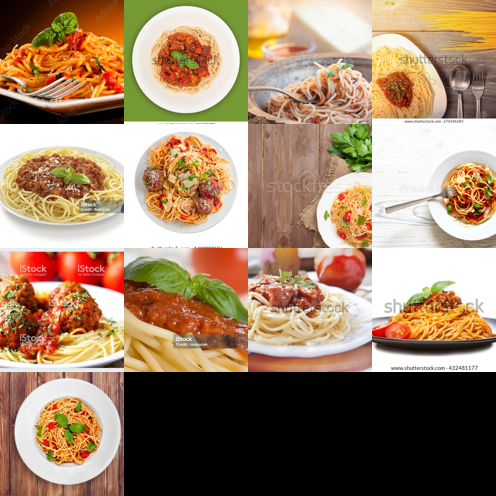

In [166]:
image_grid(images, rows=math.ceil(len(images)/4), cols=4 )